In [1]:
import pandas as pd
import spacy
from spacy import tokenizer
from spacy import displacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.metrics import accuracy_score ,classification_report
import gensim
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.models import LsiModel ,TfidfModel
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [33]:
plt.rcParams['figure.figsize'] = [12,5]

In [3]:
df = pd.read_csv(r"C:\Users\tharu\Downloads\fake_news_data.csv")

In [4]:
df.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


In [6]:
print(df.columns)
print('shape',df.shape)

Index(['title', 'text', 'date', 'fake_or_factual'], dtype='object')
shape (198, 4)


In [7]:
df['fake_or_factual'].value_counts()

fake_or_factual
Factual News    100
Fake News        98
Name: count, dtype: int64

### POS tagging

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
fake = df[df['fake_or_factual'] == 'Fake News']
factual = df[df['fake_or_factual'] == 'Factual News']

In [10]:
fake_spacydoc = list(nlp.pipe(fake['text']))
factual_spacydoc = list(nlp.pipe(factual['text']))

In [11]:
def extract_tokens_tag(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_ ,i.pos_) for i in doc]

In [12]:
fake_tagsdf = []
columns = ['tokens', 'net_tag' ,'pos_tag']

In [13]:
for ix , doc in enumerate(fake_spacydoc):
    tags =extract_tokens_tag(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [14]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [15]:
fake_tagsdf.head()

,tokens,net_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [16]:
fact_tagsdf = []
columns = ['tokens', 'net_tag' ,'pos_tag']

In [17]:
for ix , doc in enumerate(factual_spacydoc):
    tags =extract_tokens_tag(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [18]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [19]:
fake_pos_counts = fake_tagsdf.groupby(['tokens','pos_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [20]:
fake_pos_counts.head()

,tokens,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875


In [21]:
fact_pos_counts = fact_tagsdf.groupby(['tokens','pos_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [22]:
fact_pos_counts.head()

,tokens,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789


In [23]:
fact_pos_counts.groupby(['pos_tag'])['tokens'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
NUM       203
PRON       81
ADP        70
AUX        44
SCONJ      39
Name: tokens, dtype: int64

In [24]:
fake_pos_counts.groupby(['pos_tag'])['tokens'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
NUM       221
PRON       99
ADP        88
AUX        58
SCONJ      54
Name: tokens, dtype: int64

### Named Entities

In [25]:
fake_ne = fake_tagsdf[fake_tagsdf['net_tag']!=""].groupby(['tokens','net_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [26]:
fact_ne = fact_tagsdf[fact_tagsdf['net_tag']!=""].groupby(['tokens','net_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

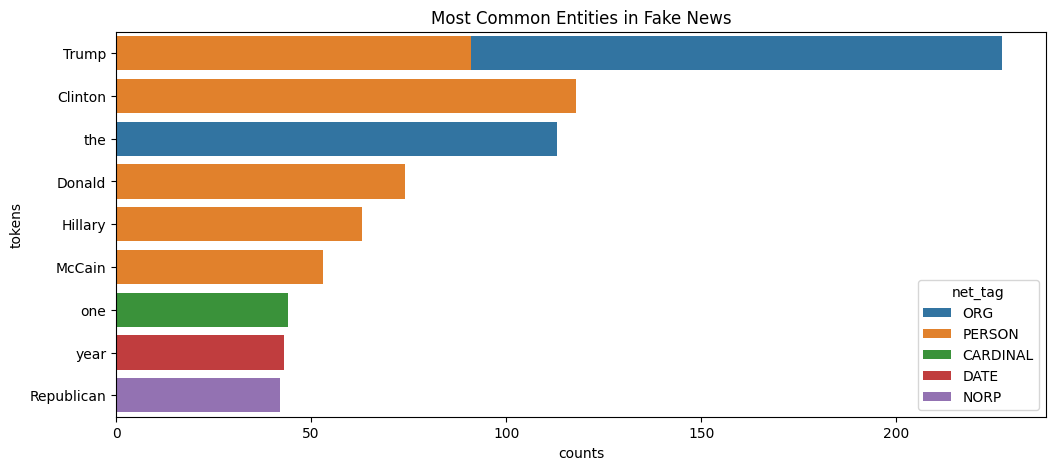

In [34]:
sns.barplot(
    x = 'counts',
    y = 'tokens',
    hue = 'net_tag',
    data = fake_ne[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Fact News')]

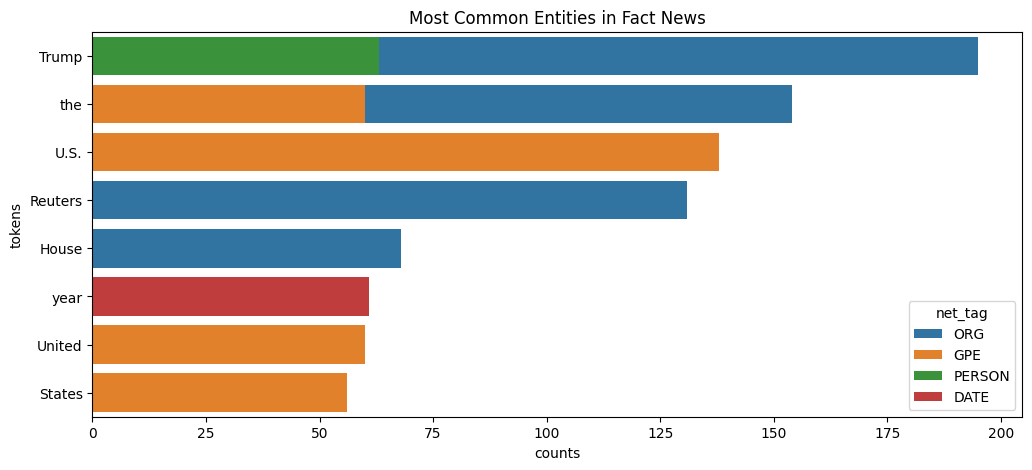

In [35]:
sns.barplot(
    x = 'counts',
    y = 'tokens',
    hue = 'net_tag',
    data = fact_ne[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Fact News')

## Text Pre-processing 

In [37]:
# a lot of the factual news has a location tag at the beginning of the article
df['text_clean'] = df.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

In [38]:
# lowercase 
df['text_clean'] = df['text_clean'].str.lower()

In [39]:
# remove punctuation
df['text_clean'] = df.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [40]:
# stop words
en_stopwords = stopwords.words('english')
print(en_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [65]:
words = []
for i in df['text']:
    word_token = word_tokenize(i)
    for j in word_token:
        words.append(j)

In [82]:
unigrams = pd.Series(nltk.ngrams(words,1))

In [84]:
unigrams.value_counts()[:10]

(the,)     3734
(,,)       3607
(.,)       2421
(to,)      2140
(of,)      1806
(and,)     1630
(a,)       1595
(in,)      1338
(s,)        954
(that,)     939
Name: count, dtype: int64

In [76]:
df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [77]:
# tokenize 
df['text_clean'] = df.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [78]:
# lemmatize
lemmatizer = WordNetLemmatizer()
df["text_clean"] = df["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [79]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [92]:
# most common unigrams after preprocessing
tokens_clean = sum(df['text_clean'], [])
unigrams_clean = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()) 
print(unigrams_clean[:10])

(said,)          560
(trump,)         520
(u,)             255
(state,)         250
(president,)     226
(would,)         210
(one,)           141
(year,)          128
(republican,)    128
(also,)          124
Name: count, dtype: int64


In [108]:
# most common unigrams before preprocessing
unigrams.value_counts()[:10]

(the,)     3734
(,,)       3607
(.,)       2421
(to,)      2140
(of,)      1806
(and,)     1630
(a,)       1595
(in,)      1338
(s,)        954
(that,)     939
Name: count, dtype: int64

In [109]:
# most common bigrams after preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()) 
print(bigrams[:10])

(donald, trump)        92
(united, state)        80
(white, house)         72
(president, donald)    42
(hillary, clinton)     31
(new, york)            31
(image, via)           29
(supreme, court)       29
(official, said)       26
(food, stamp)          24
Name: count, dtype: int64


### Sentiment Analysis 

In [110]:
# use vader so we also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

In [111]:
df['vader_sentiment_score'] = df['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

In [113]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

df['vader_sentiment_label'] = pd.cut(df['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

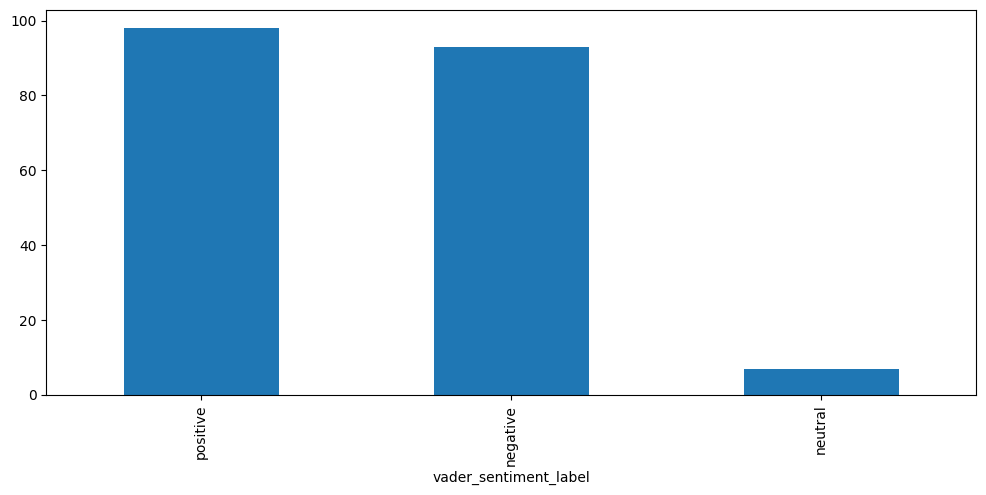

In [115]:
df['vader_sentiment_label'].value_counts().plot.bar()

C:\Users\tharu\AppData\Local\Temp\ipykernel_8728\2030586678.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

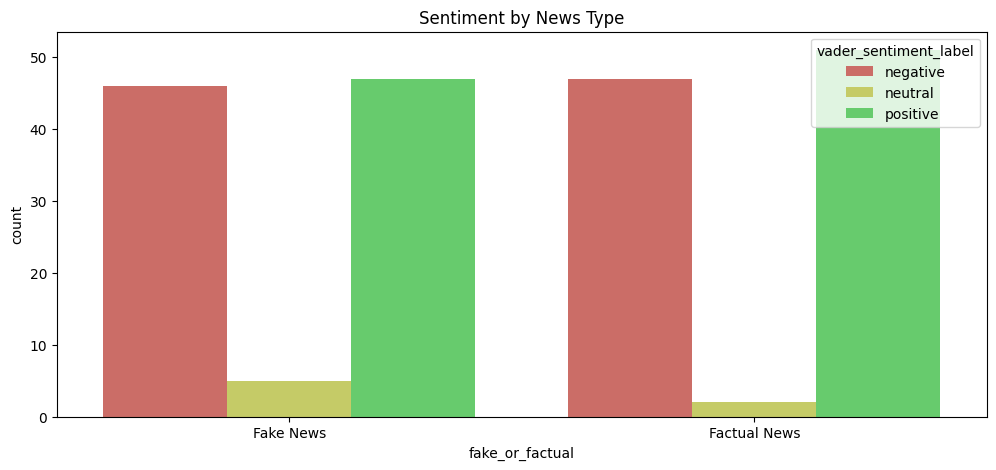

In [116]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = df
).set(title='Sentiment by News Type')

### LDA 

In [117]:
# fake news data vectorization
fake_news_text = df[df['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [118]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

In [119]:
for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

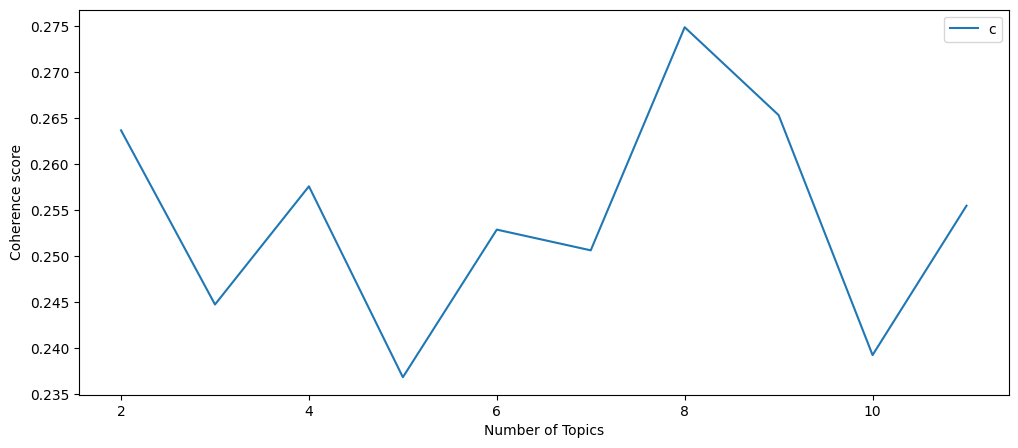

In [120]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
num_topics_fake = 8

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.010*"trump" + 0.008*"clinton" + 0.005*"said" + 0.005*"woman" + 0.005*"president" + 0.004*"year" + 0.003*"state" + 0.003*"one" + 0.003*"republican" + 0.003*"time"'),
 (1,
  '0.011*"trump" + 0.006*"said" + 0.005*"time" + 0.005*"state" + 0.003*"u" + 0.003*"clinton" + 0.003*"stamp" + 0.003*"new" + 0.003*"president" + 0.003*"one"'),
 (2,
  '0.009*"trump" + 0.005*"clinton" + 0.004*"would" + 0.004*"state" + 0.004*"one" + 0.004*"u" + 0.004*"president" + 0.003*"said" + 0.003*"people" + 0.003*"time"'),
 (3,
  '0.009*"trump" + 0.004*"president" + 0.004*"would" + 0.003*"woman" + 0.003*"said" + 0.003*"state" + 0.003*"million" + 0.003*"people" + 0.003*"like" + 0.003*"clinton"'),
 (4,
  '0.006*"trump" + 0.005*"said" + 0.004*"people" + 0.004*"state" + 0.004*"would" + 0.003*"u" + 0.003*"obama" + 0.003*"also" + 0.003*"one" + 0.003*"republican"'),
 (5,
  '0.004*"trump" + 0.004*"u" + 0.004*"said" + 0.003*"president" + 0.003*"woman" + 0.003*"state" + 0.003*"obama" + 0.003*"people" + 0.003*"clinto

### TF-IDF & LSA 

In [122]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [127]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()      

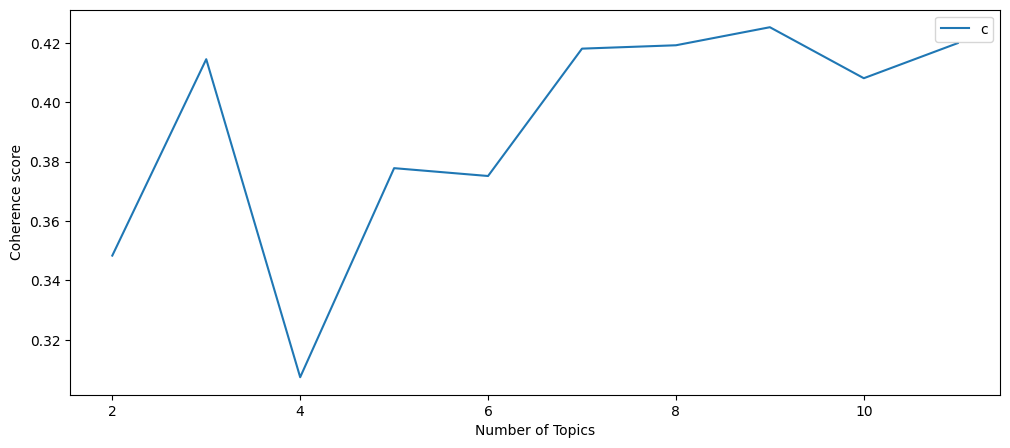

In [128]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [129]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=3)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '-0.299*"boiler" + -0.253*"room" + -0.250*"acr" + -0.186*"jay" + -0.185*"animal" + -0.176*"episode" + -0.147*"analysis" + -0.122*"dyer" + -0.119*"moralist" + -0.119*"savant"'),
 (2,
  '-0.218*"school" + 0.194*"clinton" + 0.165*"conference" + -0.151*"county" + -0.136*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.096*"email"')]

### Predict fake or factual news

In [130]:
df.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [132]:
X = [','.join(map(str, l)) for l in df['text_clean']]
Y = df['fake_or_factual']

In [133]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [135]:
# split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [136]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [146]:
y_pred_lr = lr.predict(X_test)
print('accuracy:',accuracy_score(y_pred_lr, y_test))

accuracy: 0.85


In [147]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.85      0.81      0.83        27
   Fake News       0.85      0.88      0.87        33

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



In [148]:
svm = SGDClassifier().fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [149]:
print('accuracy:',accuracy_score(y_pred_svm, y_test))

accuracy: 0.9166666666666666


In [150]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.92      0.89      0.91        27
   Fake News       0.91      0.94      0.93        33

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.92        60
weighted avg       0.92      0.92      0.92        60



In [151]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB().fit(X_train,y_train)

In [152]:
y_pred_mnb = MNB.predict(X_test)
print('accuracy:',accuracy_score(y_pred_mnb, y_test))

accuracy: 0.8833333333333333


In [153]:
print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

Factual News       0.81      0.96      0.88        27
   Fake News       0.96      0.82      0.89        33

    accuracy                           0.88        60
   macro avg       0.89      0.89      0.88        60
weighted avg       0.90      0.88      0.88        60

